In [7]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import ipdb
import ipywidgets as widgets
from IPython.display import display
from tqdm import tqdm
import matplotlib.path as path
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import HTML
from line_profiler import LineProfiler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances


# Current to-do
- Need to write tests for what I've done so far (spend another hour on this)
- Need to animate 2D simulation (1 hr)
- Then need a good 2D simulation that can be initialized with a map (of U.S. or California) (1 hour)
- then need to include patient recovery (1 hour)
    - and the recovery rate needs to be functionally dependent on age, which can be toggled
- then need to implement lockdown (2 hours)
    
    
    
running list of free parameters:
- threshold
- age dependence of recovery (to be implemented)

# Step 1. Naive simulation.
- Simulate N bodies
- There's a transmission rate 
- At each time step, all the infected people have some *transmission rate* probability of infecting everyone.
- Just tracking rate of *infection* through. Don't worry about death.
- 0 dimensional problem

In [73]:
# 1 is healthy. 0 is not.
def infect(df, trans_rate, day_name): # need to speed up
    """
    Simulates a single day of infection. Each infected person
    
    NOTE: a 0 counts as infected, while a 1 is healthy.
    
    Inputs:
        df : (pandas DataFrame) object holding all values of infected people. Each
                        column of "infected day _" corresponds to a different day, 
                        with "_" being some integer or float. The "name" column
                        assigns a name to each object, independent of index. In
                        the infected columns, a 0 counts as infected, while a 1 is 
                        healthy.
        trans_rate : (float) rate of transmission between individuals. infection
                        is performed in a probabilistic manner, casting it as a 
                        draw from a binomial distribution with a rate of 
                        1 - trans_rate.
        day_name : (float or int) the day of this infection, used to create a new
                        column in the dataframe tracking the day's infections.
                        
    Outputs:
        df : (pandas DataFrame) object, same as the input, but with a new column
                        holding this day's infected results.
    """
    p = 1 - trans_rate # to confer correct healthy/sick convention.
    for i in range(len(df)):
        if df[f'infected day {day_name - 1}'][i] == 0.0: # if infected, infect others
            infect_col = np.random.binomial(size=len(df), p=p, n=1) # 1 toss, siz
            
            # next, create a new column to track this day's number of infected individuals
            if i == 0:
                df[f"infected day {day_name}"] = df[f"infected day {day_name - 1}"] * infect_col
            else:
                df[f"infected day {day_name}"] = df[f"infected day {day_name}"] * infect_col
    return df

def simulate(N, trans_rate, t_steps, N_initial):
    """
    Simulates an infection run.
    
    Inputs:
        N : (int) number of individuals in the system.
        trans_rate : (float) rate of transmission between individuals. infection
                        is performed in a probabilistic manner, casting it as a 
                        draw from a binomial distribution with a rate of 
                        1 - trans_rate.
        t_steps : (int) number of time steps ("days") to consider.
        N_initial : (int) number of initially infected individuals.
        
    Outputs:
         df : (pandas DataFrame) object holding all values of infected people. Each
                        column of "infected day _" corresponds to a different day, 
                        with "_" being some integer or float. The "name" column
                        assigns a name to each object, independent of index. In
                        the infected columns, a 0 counts as infected, while a 1 is 
                        healthy. 
    """
    # making separate name column because indices get messy. 
    # other cols later.
    d = {'name': np.arange(N), 'infected day 0': np.ones(N)} 

    df = pd.DataFrame(data=d)
    
    df.loc[:N_initial, 'infected day 0'] = 0 # Make first N_initial people sick 
    t = 1
    for t in tqdm(range(1, t_steps), position=0, leave=True):
        df = infect(df, trans_rate, t)
    return df
        

In [153]:
%%time
df = simulate(10000, .001, 30, 10)

100%|██████████| 29/29 [03:21<00:00,  6.95s/it]

CPU times: user 3min 4s, sys: 3.03 s, total: 3min 7s
Wall time: 3min 21s


In [70]:
df.columns

Index(['name', 'infected day 0', 'infected day 1', 'infected day 2',
       'infected day 3', 'infected day 4', 'infected day 5'],
      dtype='object')

Text(0, 0.5, 'Number of infected individuals')

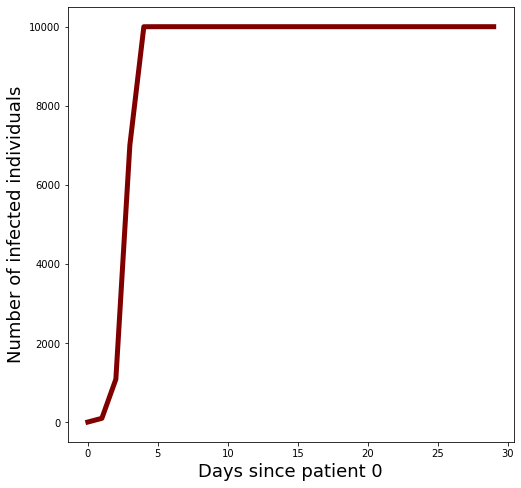

In [157]:
plt.figure(figsize=(8,8))
infections = np.array([df[col].sum() for col in df.columns if 'infected day' in col])
plt.plot(np.arange(len(infections)), 10000 - infections, lw=5, color='maroon')
plt.xlabel('Days since patient 0', fontsize=18)
plt.ylabel('Number of infected individuals', fontsize=18)
# plt.xscale('log')
# plt.yscale('log')

# Step 2. 1D simulation
- Same as before, but now accounting for *distance* between people
- a distance factor, within some certain range, is multiplied to base transmission factor
- randomly initialize the N bodies around the origin

In [2]:
def distance_multiplier(df, r1, r2, thresh, power):
    """
    returns a distance multiplier based on two individuals, to be smacked 
    onto the transmission rate, that is always less than 1. 
    
    if the metric distance (defined within) is below thresh, multiplier of 1.
    Anything greater falls off as distance to the power law. Power is some law greater than 0.
    
    Inputs:
        df : (pandas DataFrame) object holding all values of infected people. Each
                            column of "infected day _" corresponds to a different day, 
                            with "_" being some integer or float. The "name" column
                            assigns a name to each object, independent of index. In
                            the infected columns, a 0 counts as infected, while a 1 is 
                            healthy.
        r1 : (float) position of first point.
        r2 : (float) position of second point.
        thresh : (float) distance less than which infection is transmitted at the trans_rate;
                            that is, less than which this function returns a value of 1. At
                            a distance greater than this, this function returns 1/distance^power.
        power : (float) Greater than 0. Power to which the multiplier falls off if the distance
                            is greater than some threshold.
    
    Outputs:
        multiplier : (float) suppresses the rate of transmission.
    """
    def metric_distance(r1, r2):
        """
        Returns distance between two points.
        
        Inputs:
            r1 : (float) position of first point.
            r2 : (float) position of second point.
        
        Outputs:
            dist : (float) distance between the two points.
            
        """
        if type(r1) != float:
            raise AssertionError("r1 must be a float.")
        if type(r2) != float and type(r2) != np.float64 and type(r2) != np.float32:
            raise AssertionError("r2 must be a float.")
        
        dist = abs(r1 - r2)
        return dist
    # first check input types
    if type(thresh) != int and type(thresh) != float:
        raise AssertionError("wrong type for thresh.")
    if type(df) != pd.core.frame.DataFrame:
        raise AssertionError("df must be a pandas DataFrame.")
    if type(r1) != float:
        raise AssertionError("r1 must be a float.")

    if type(r2) != float and type(r2) != np.float64 and type(r2) != np.float32:
        raise AssertionError("r2 must be a float.")
    if type(power) != float and type(power) != int:
        raise AssertionError("power must be a float or integer.")
    
        
    # first check input values
    if thresh <= 0:
        raise AssertionError("thresh must be positive.")
    if power <= 0:
        raise AssertionError("power must be positive.")
        
    dist = metric_distance(r1, r2)
    if dist < thresh:
        return 1.
    else:
        return 1/pow(dist, power)


In [114]:
def infect1D(df, trans_rate, day_name, thresh, power): # need to speed up
    """
    Simulates a single day of infection in 1D. 
    
    NOTE: a 0 counts as infected, while a 1 is healthy.
    
    Inputs:
        df : (pandas DataFrame) object holding all values of infected people. Each
                        column of "infected day _" corresponds to a different day, 
                        with "_" being some integer or float. The "name" column
                        assigns a name to each object, independent of index. In
                        the infected columns, a 0 counts as infected, while a 1 is 
                        healthy.
        trans_rate : (float) rate of transmission between individuals. infection
                        is performed in a probabilistic manner, casting it as a 
                        draw from a binomial distribution with a rate of 
                        1 - trans_rate.
        day_name : (float or int) the day of this infection, used to create a new
                        column in the dataframe tracking the day's infections.
                        
    Outputs:
        df : (pandas DataFrame) object, same as the input, but with a new column
                        holding this day's infected results.
    """
    df[f"infected day {day_name}"] = df[f"infected day {day_name - 1}"].copy()
    infected = df[df[f'infected day {day_name}'] == 0.]
    if len(infected) == len(df): # everyone is infected
        return df
    for i in range(len(infected)): # this is number of rows, right?            
        # find distance multiplier between this ind and all others
        uninfected = df[df[f'infected day {day_name}'] == 1.]
        r2 = infected['locs'].values[i] # time this versus

        subs = uninfected['locs'].apply(lambda x:abs(x - r2))
        multiplier_col = subs.apply(lambda x:1/pow(x, power) if x > thresh else 1)

        # now get different p values

        p = 1 - (multiplier_col * trans_rate)

        infect_col = np.random.binomial(size=len(uninfected), p=p, n=1) # 1 toss

        # next, create a new column to track this day's number of infected individuals
        
        df.loc[df[f'infected day {day_name}'] == 1., f'infected day {day_name}'] *= infect_col

#         uninfected[f"infected day {day_name}"] = uninfected[f"infected day {day_name}"] * infect_col
    return df


In [115]:
def simulate1D(N, trans_rate, t_steps, N_initial, thresh, power, 
               distrib_pop, distrib_infec, kwargs_for_pop={}, 
               kwargs_for_infec={}):
    """
    Simulates an infection run in 1D.
    
    Inputs:
        N : (int) number of individuals in the system.
        trans_rate : (float) rate of transmission between individuals. infection
                        is performed in a probabilistic manner, casting it as a 
                        draw from a binomial distribution with a rate of 
                        1 - trans_rate.
        t_steps : (int) number of time steps ("days") to consider.
        N_initial : (int) number of initially infected individuals.
        thresh : (float) distance less than which infection is transmitted at the trans_rate;
                            that is, less than which this function returns a value of 1. At
                            a distance greater than this, this function returns 1/distance^power.
        power : (float) Greater than 0. Power to which the multiplier falls off if the distance
                            is greater than some threshold.
        distrib_pop : (func) distribution function to determine how individuals are initialized.
        distrib_infec : (func) distribution function to determine how initial infections are initialized.
        kwargs_for_pop : (dict) keyword arguments passed to the distrib_pop distribution type. 
                        Size not included.
        kwargs_for_infec : (dict) keyword arguments passed to the distrib_infect distribution type. Size not 
                        included.
        
    Outputs:
         df : (pandas DataFrame) object holding all values of infected people. Each
                        column of "infected day _" corresponds to a different day, 
                        with "_" being some integer or float. The "name" column
                        assigns a name to each object, independent of index. In
                        the infected columns, a 0 counts as infected, while a 1 is 
                        healthy. 
    """
    # making separate name column because indices get messy. 
    # other cols later.
    
    def initial_infect(df, distrib_infec, N_initial, kwargs):
        """
        Based on the specified distribution functions, this initializes the infected
        population.
        
        Inputs:
             df : (pandas DataFrame) object holding all values of infected people. Each
                        column of "infected day _" corresponds to a different day, 
                        with "_" being some integer or float. The "name" column
                        assigns a name to each object, independent of index. In
                        the infected columns, a 0 counts as infected, while a 1 is 
                        healthy. 
            distrib_infec : (func) distribution function to determine how initial infections are initialized.
            **kwargs : (dict) keyword arguments passed to the distrib_infect distribution type. Size not 
                        included.
                        
        Outputs:
            df : (pandas DataFrame) object holding all values of infected people. Each
                        column of "infected day _" corresponds to a different day, 
                        with "_" being some integer or float. The "name" column
                        assigns a name to each object, independent of index. In
                        the infected columns, a 0 counts as infected, while a 1 is 
                        healthy. This time, initialized with the initially infected individuals.
        """
        infected = distrib_infec(size=N_initial, **kwargs)
        for inf in infected:
            uninfected = df[df['infected day 0'] == 1] # want to find a person that isn't infected
            closest_in_frame = uninfected['locs'].sub(inf).abs().idxmin() 
            df.loc[closest_in_frame, 'infected day 0'] = 0 # make that closest individual infected
        return df
    
    
    name = np.arange(N)
    zero_infected = np.ones(N)
    locs = distrib_pop(size=N, **kwargs_for_pop)
    d = {'name': np.arange(N), 'infected day 0': zero_infected, 'locs' : locs} 

    df = pd.DataFrame(data=d)
    
    df = initial_infect(df, distrib_infec, N_initial, kwargs_for_infec) # now infected
    for t in tqdm(range(1, t_steps), position=0, leave=True):
        df = infect1D(df, trans_rate, t, thresh, power)
    return df
        

## Testing out some speed

In [116]:
N = 10000
name = np.arange(N)
distrib_pop = np.random.uniform
kwargs_for_pop = {'low':-10, 'high':10}
locs = distrib_pop(size=N, **kwargs_for_pop)
zero_infected = np.ones(N)
d = {'name': np.arange(N), 'infected day 0': zero_infected, 'locs' : locs} 

df1D_test = pd.DataFrame(data=d)

In [117]:
%%timeit
power = 2
thresh = 2

r2 = df1D_test['locs'][1]
df1D_test['locs'].apply(lambda x:distance_multiplier(df1D_test, x, r2, thresh, power)) 

44 ms ± 6.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [118]:
%%timeit

# this is certainly around 25% faster
power = 3
thresh = 2
r2 = df1D_test['locs'][1]
df1D_test['subs'] = df1D_test['locs'].apply(lambda x:abs(x - r2))
df1D_test['metrics'] = df1D_test['subs'].apply(lambda x:1/pow(x, power) if x > thresh else 1)

10.6 ms ± 332 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## AND NOW: profiling

In [119]:
lp = LineProfiler()
lp.add_function(infect1D)   # add additional function to profile
lp_wrapper = lp(simulate1D)
lp_wrapper(10000, .1, 30, 10, 2., 3, np.random.uniform, np.random.normal, 
           kwargs_for_pop={'low':-10, 'high':10}, kwargs_for_infec={'loc': 1, 'scale': 2})
lp.print_stats()

100%|██████████| 29/29 [01:31<00:00,  3.14s/it]


Timer unit: 1e-06 s

Total time: 90.959 s
File: <ipython-input-114-bccc3c7b8aca>
Function: infect1D at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def infect1D(df, trans_rate, day_name, thresh, power): # need to speed up
     2                                               """
     3                                               Simulates a single day of infection in 1D. 
     4                                               
     5                                               NOTE: a 0 counts as infected, while a 1 is healthy.
     6                                               
     7                                               Inputs:
     8                                                   df : (pandas DataFrame) object holding all values of infected people. Each
     9                                                                   column of "infected day _" corresponds to a different day, 
    10    

In [159]:
# df1D = simulate1D(100000, .1, 30, 1, 2, 3, np.random.uniform, low=-10, high=10)
df1D = simulate1D(10000, .001, 30, 10, 1., 3, np.random.uniform, np.random.normal, kwargs_for_pop={'low':-20, 'high':20}, kwargs_for_infec={'loc': 1, 'scale': .1})

# it's likely that the distance metric needs to be suppressed even more, not transmission!

100%|██████████| 29/29 [16:36<00:00, 34.35s/it]


Text(0.5, 1.0, 'Spread of disease: N = 100,000 individuals')

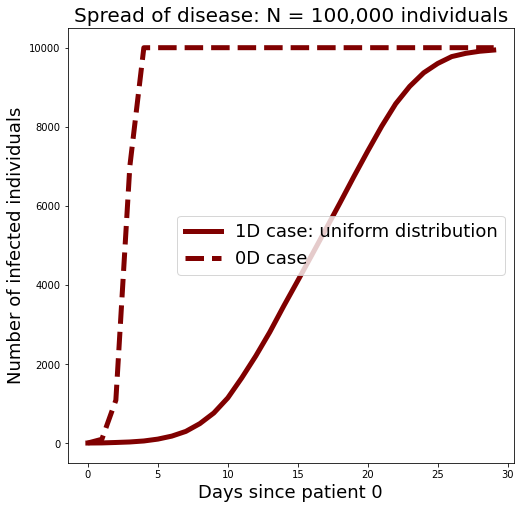

In [166]:
plt.figure(figsize=(8,8))
infections1D = np.array([df1D[col].sum() for col in df1D.columns if 'infected day' in col])
plt.plot(np.arange(len(infections1D)), 10000 - infections1D, lw=5, color='maroon', 
         linestyle='-', label='1D case: uniform distribution')
plt.plot(np.arange(len(infections)), 10000 - infections, lw=5, color='maroon',
        linestyle='--', label='0D case')
plt.xlabel('Days since patient 0', fontsize=18)
plt.ylabel('Number of infected individuals', fontsize=18)
plt.legend(fontsize=18)
plt.title('Spread of disease: N = 100,000 individuals', fontsize=20)
# plt.xscale('log')
# plt.yscale('log')

In [155]:
# np.savetxt('1D_simulation_test.txt', df1D)
# for df1D = simulate1D(10000, .001, 30, 10, 1., 3, np.random.uniform, 
# np.random.normal, kwargs_for_pop={'low':-20, 'high':20}, kwargs_for_infec={'loc': 1, 'scale': 2})


## Histogram of each day

In [162]:
def animate_histogram(df, title):
    """
    animates a histogram.
    
    """
    # adapted from https://matplotlib.org/gallery/animation/animated_histogram.html

    n, bins = np.histogram(df['locs'][df['infected day 29'] == 0], 30)
    infect_cols = [col for col in df.columns if 'infected day' in col]

    # get the corners of the rectangles for the histogram
    left = np.array(bins[:-1])
    right = np.array(bins[1:])
    bottom = np.zeros(len(left))
    top = bottom + n
    nrects = len(left)

    ###############################################################################
    # Here comes the tricky part -- we have to set up the vertex and path codes
    # arrays using `.Path.MOVETO`, `.Path.LINETO` and `.Path.CLOSEPOLY` for each
    # rect.
    #
    # * We need 1 ``MOVETO`` per rectangle, which sets the initial point.
    # * We need 3 ``LINETO``'s, which tell Matplotlib to draw lines from
    #   vertex 1 to vertex 2, v2 to v3, and v3 to v4.
    # * We then need one ``CLOSEPOLY`` which tells Matplotlib to draw a line from
    #   the v4 to our initial vertex (the ``MOVETO`` vertex), in order to close the
    #   polygon.
    #
    # .. note::
    #
    #   The vertex for ``CLOSEPOLY`` is ignored, but we still need a placeholder
    #   in the ``verts`` array to keep the codes aligned with the vertices.
    nverts = nrects * (1 + 3 + 1)
    verts = np.zeros((nverts, 2))
    codes = np.ones(nverts, int) * path.Path.LINETO
    codes[0::5] = path.Path.MOVETO
    codes[4::5] = path.Path.CLOSEPOLY
    verts[0::5, 0] = left
    verts[0::5, 1] = bottom
    verts[1::5, 0] = left
    verts[1::5, 1] = top
    verts[2::5, 0] = right
    verts[2::5, 1] = top
    verts[3::5, 0] = right
    verts[3::5, 1] = bottom

    ###############################################################################
    # To animate the histogram, we need an ``animate`` function, which generates
    # a random set of numbers and updates the locations of the vertices for the
    # histogram (in this case, only the heights of each rectangle). ``patch`` will
    # eventually be a `.Patch` object.
    patch = None


    def animate(i):
        # simulate new data coming in
        col = infect_cols[i]
        n, bins2 = np.histogram(df['locs'][df[col] == 0], bins=bins)
    #     top = np.log10(bottom + n)
        top = n
        verts[1::5, 1] = top
        verts[2::5, 1] = top
    #     ax.set_ylim(0, 2)
        lab = f'{col[-2:]} days after patient 0'
        label.set_text(lab)
    #     if len(all_masses[i]) == 0:
    #         return [patch, ]
        return [patch, ]

    ###############################################################################
    # And now we build the `.Path` and `.Patch` instances for the histogram using
    # our vertices and codes. We add the patch to the `~.axes.Axes` instance, and
    # setup the `.FuncAnimation` with our ``animate`` function.
    fig, ax = plt.subplots(figsize=(8,8))
    # ax.set_ylim(0, 2)
    ax.set_xlim(-20, 20)
#     ax.set_ylim(0, 10000)
    ax.set_title(title, fontsize=20)
    lab = f'{infect_cols[0][-2:]} days after patient 0'
    label = ax.text(-9, 0.9 * np.max(n), lab, fontsize=18)
    ax.set_ylabel('Number of infected individuals', fontsize=20)
    ax.set_xlabel(r'Location', fontsize=20)
    barpath = path.Path(verts, codes)
    patch = patches.PathPatch(
        barpath, facecolor='maroon', edgecolor='gray', alpha=0.5)
    ax.add_patch(patch)

    # ax.set_xlim(left[0], right[-1])
    ax.set_ylim(bottom.min(), top.max())

    return animation.FuncAnimation(fig, animate, len(infect_cols), repeat=False, blit=True)

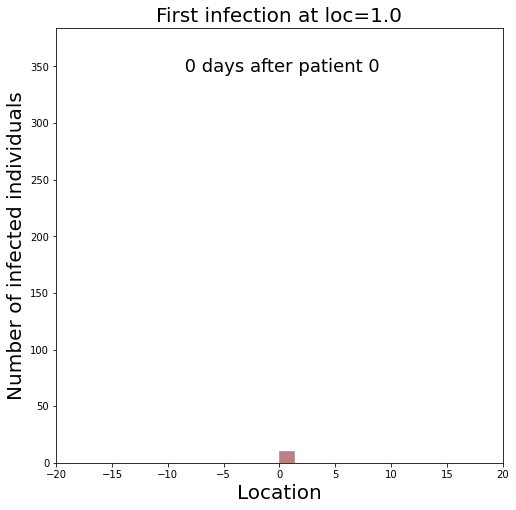

In [163]:
ani = animate_histogram(df1D, 'First infection at loc=1.0')

In [164]:
HTML(ani.to_html5_video())

In [294]:
inn = 1
df1D.iloc[(df1D['locs']-inn).abs().argsort()[:1]].index[0]

92587

# Step 3. 2D simulation
- mostly same idea as 1D. 
- modify the metric
- change locs to x
- add a y column
- initialize with 2d distributions

In [8]:
def distance_multiplier2D(df, x1, y1, x2, y2, thresh, power):
    """
    returns a distance multiplier based on two individuals, to be smacked 
    onto the transmission rate, that is always less than 1. 
    
    if the metric distance (defined within) is below thresh, multiplier of 1.
    Anything greater falls off as distance to the power law. Power is some law greater than 0.
    
    Inputs:
        df : (pandas DataFrame) object holding all values of infected people. Each
                            column of "infected day _" corresponds to a different day, 
                            with "_" being some integer or float. The "name" column
                            assigns a name to each object, independent of index. In
                            the infected columns, a 0 counts as infected, while a 1 is 
                            healthy.
        r1 : (float) position of first point.
        r2 : (float) position of second point.
        thresh : (float) distance less than which infection is transmitted at the trans_rate;
                            that is, less than which this function returns a value of 1. At
                            a distance greater than this, this function returns 1/distance^power.
        power : (float) Greater than 0. Power to which the multiplier falls off if the distance
                            is greater than some threshold.
    
    Outputs:
        multiplier : (float) suppresses the rate of transmission.
    """
    def metric_distance2D(x1, x2, y1, y2):
        """
        Returns distance between two points.
        
        Inputs:
            r1 : (float) position of first point.
            r2 : (float) position of second point.
        
        Outputs:
            dist : (float) distance between the two points.
            
        """
        if type(x1) != float:
            raise AssertionError("x1 must be a float.")
        if type(y1) != float:
            raise AssertionError("y1 must be a float.")
        if type(x2) != float and type(x2) != np.float64 and type(x2) != np.float32:
            raise AssertionError("x2 must be a float.")
        if type(y2) != float and type(y2) != np.float64 and type(y2) != np.float32:
            raise AssertionError("y2 must be a float.")
        
        
        # test speed of this versus np.sqrt apply on columns
        
        dist = sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
        return dist
    # first check input types
    if type(thresh) != int and type(thresh) != float:
        raise AssertionError("wrong type for thresh.")
    if type(df) != pd.core.frame.DataFrame:
        raise AssertionError("df must be a pandas DataFrame.")
    if type(x1) != float:
            raise AssertionError("x1 must be a float.")
    if type(y1) != float:
        raise AssertionError("y1 must be a float.")
    if type(x2) != float and type(x2) != np.float64 and type(x2) != np.float32:
        raise AssertionError("x2 must be a float.")
    if type(y2) != float and type(y2) != np.float64 and type(y2) != np.float32:
            raise AssertionError("y2 must be a float.")
    if type(power) != float and type(power) != int:
        raise AssertionError("power must be a float or integer.")
    
        
    # first check input values
    if thresh <= 0:
        raise AssertionError("thresh must be positive.")
    if power <= 0:
        raise AssertionError("power must be positive.")
        
    dist = metric_distance(x1, y1, x2, y2)
    if dist < thresh:
        return 1.
    else:
        return 1/pow(dist, power)


In [96]:
def infect2D(df, trans_rate, day_name, thresh, power, dist_matrix):
    """
    Simulates a single day of infection in 1D. 
    
    NOTE: a 0 counts as infected, while a 1 is healthy.
    
    Inputs:
        df : (pandas DataFrame) object holding all values of infected people. Each
                        column of "infected day _" corresponds to a different day, 
                        with "_" being some integer or float. The "name" column
                        assigns a name to each object, independent of index. In
                        the infected columns, a 0 counts as infected, while a 1 is 
                        healthy.
        trans_rate : (float) rate of transmission between individuals. infection
                        is performed in a probabilistic manner, casting it as a 
                        draw from a binomial distribution with a rate of 
                        1 - trans_rate.
        day_name : (float or int) the day of this infection, used to create a new
                        column in the dataframe tracking the day's infections.
        dist_matrix : (numpy.ndarray) distance matrix holding the distances between all individuals.
                        
    Outputs:
        df : (pandas DataFrame) object, same as the input, but with a new column
                        holding this day's infected results.
    """
    df[f"infected day {day_name}"] = df[f"infected day {day_name - 1}"].copy()
    infected = df[df[f'infected day {day_name}'] == 0.]
    
    if len(infected) == len(df): # everyone is infected
        return df
    for i in range(len(infected)): # this is number of rows, right?            
        # find distance multiplier between this ind and all others
#         uninfected = df[df[f'infected day {day_name}'] == 1.]
        dists = dist_matrix[infected.index[i]] # distances to everything from infected.values[i], loosely
        multiplier_col = np.where(dists > thresh, 1/np.power(dists, power), np.ones_like(dists)) 
        # now get different p values

        p = 1 - (multiplier_col * trans_rate)
#         ipdb.set_trace()
        infect_col = np.random.binomial(size=len(df), p=p, n=1) # 1 toss

        # next, create a new column to track this day's number of infected individuals
        
#         df.loc[df[f'infected day {day_name}'] == 1., f'infected day {day_name}'] *= infect_col
        df.loc[:, f'infected day {day_name}'] *= infect_col
    return df


In [97]:
def simulate2D(N, trans_rate, t_steps, N_initial, thresh, power, 
               distrib_pop, distrib_infec, kwargs_for_pop={}, 
               kwargs_for_infec={}):
    """
    NOT YET IMPLEMENTED
    Simulates an infection run in 1D.
    
    Inputs:
        N : (int) number of individuals in the system.
        trans_rate : (float) rate of transmission between individuals. infection
                        is performed in a probabilistic manner, casting it as a 
                        draw from a binomial distribution with a rate of 
                        1 - trans_rate.
        t_steps : (int) number of time steps ("days") to consider.
        N_initial : (int) number of initially infected individuals.
        thresh : (float) distance less than which infection is transmitted at the trans_rate;
                            that is, less than which this function returns a value of 1. At
                            a distance greater than this, this function returns 1/distance^power.
        power : (float) Greater than 0. Power to which the multiplier falls off if the distance
                            is greater than some threshold.
        distrib_pop : (func) distribution function to determine how individuals are initialized.
        distrib_infec : (func) distribution function to determine how initial infections are initialized.
        kwargs_for_pop : (dict) keyword arguments passed to the distrib_pop distribution type. 
                        Size not included.
        kwargs_for_infec : (dict) keyword arguments passed to the distrib_infect distribution type. Size not 
                        included.
        
    Outputs:
         df : (pandas DataFrame) object holding all values of infected people. Each
                        column of "infected day _" corresponds to a different day, 
                        with "_" being some integer or float. The "name" column
                        assigns a name to each object, independent of index. In
                        the infected columns, a 0 counts as infected, while a 1 is 
                        healthy. 
    """
    # making separate name column because indices get messy. 
    # other cols later.
    name = np.arange(N)
    zero_infected = np.ones(N)
    pop = initialize_pop_2D(N, distrib_pop, **kwargs_for_pop)
    x, y = pop[:, 0], pop[:, 1]
    d = {'name': np.arange(N), 'infected day 0': zero_infected, 'x' : x, 'y' : y} 

    df = pd.DataFrame(data=d)
    
    
    pop = initialize_pop_2D(N_initial, distrib_infec, **kwargs_for_infec)
    x, y = pop[:, 0], pop[:, 1]
    all_infected = np.zeros(N_initial)
    d_infec = {'name': np.arange(N, N + N_initial), 'infected day 0': all_infected, 'x' : x, 'y' : y}
    df_infec = pd.DataFrame(data=d_infec)
    
    df = df.append(df_infec, ignore_index = True)
    
    
    
    
    dist_matrix = euclidean_distances(df[['x', 'y']], df[['x', 'y']])

    for t in tqdm(range(1, t_steps), position=0, leave=True):
        df = infect2D(df, trans_rate, t, thresh, power, dist_matrix)
    return df
        

In [98]:
def initialize_pop_2D(N, distrib, **kwargs):
    '''
    This will change once we have the U.S. map.
    
    distrib: size is not a thing again.
    '''
    pop = distrib(size=(N, 2), **kwargs)
    
    return pop

In [102]:
# %%time


df2D = simulate2D(10000, .001, 30, 10, 1., 3, np.random.uniform, np.random.normal, 
                  kwargs_for_pop={'low':-10, 'high':10}, 
                  kwargs_for_infec={'loc': 1, 'scale': 2})

100%|██████████| 29/29 [00:17<00:00,  1.68it/s]


Text(0.5, 1.0, 'Spread of disease: N = 100,000 individuals')

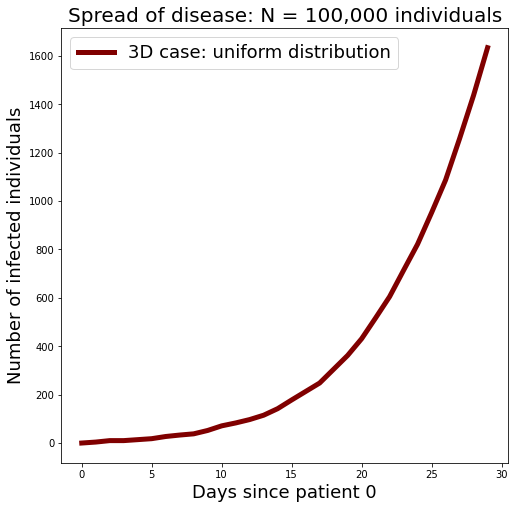

In [104]:
plt.figure(figsize=(8,8))
infections2D = np.array([df2D[col].sum() for col in df2D.columns if 'infected day' in col])
plt.plot(np.arange(len(infections2D)), 10000 - infections2D, lw=5, color='maroon', 
         linestyle='-', label='3D case: uniform distribution')
# plt.plot(np.arange(len(infections)), 10000 - infections, lw=5, color='maroon',
#         linestyle='--', label='0D case')
plt.xlabel('Days since patient 0', fontsize=18)
plt.ylabel('Number of infected individuals', fontsize=18)
plt.legend(fontsize=18)
plt.title('Spread of disease: N = 100,000 individuals', fontsize=20)
# plt.xscale('log')
# plt.yscale('log')

In [120]:
np.shape(Y)

(19, 19)

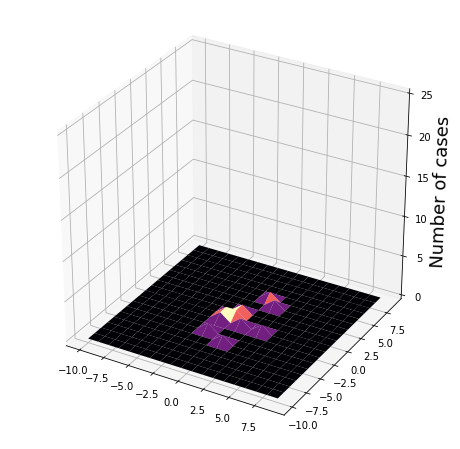

In [152]:
infected = df2D[df2D['infected day 29'] == 0]
H, xedges, yedges = np.histogram2d(infected['x'], infected['y'], 
                                   bins=(np.linspace(-10, 10, 20), np.linspace(-10,10, 20)))
infect_cols = [col for col in df2D.columns if 'infected day' in col]
def animate(i, plot):
    # simulate new data coming in
    ax.clear()
    infect_col = infect_cols[i]
    infected = df2D[df2D[infect_col] == 0]
    H, xedges, yedges = np.histogram2d(infected['x'], infected['y'], 
                                   bins=(np.linspace(-10, 10, 20), np.linspace(-10,10, 20)))
    plot = ax.plot_surface(X, Y, H, cmap='magma')
    ax.set_zlim(0,25)
    ax.set_zlabel('Number of cases', fontsize=18)

    return plot,


X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
plot = [ax.plot_surface(X, Y, H, cmap='magma')]
ax.set_zlim(0,25)
ax.set_zlabel('Number of cases', fontsize=18)
# ax.set_xlim(left[0], right[-1])
# ax.set_ylim(bottom.min(), top.max())

ani = animation.FuncAnimation(fig, animate, len(infect_cols), fargs=(plot), repeat=False, blit=True)

In [153]:
HTML(ani.to_html5_video())

## test that 2D distance metric.


In [197]:
a = np.random.rand(10000,10000)
b = [[1,1], [0, 1], [2, 1]]

In [212]:
distances = pdist(b, metric='euclidean')
dist_matrix = squareform(distances)

In [214]:
dist_matrix[1, 0]

1.0

In [176]:
from scipy.spatial.distance import pdist, squareform


In [177]:
distances = pdist(a, metric='euclidean')
dist_matrix = squareform(distances)

In [178]:
dist_matrix

array([[ 0.        , 13.14699953, 12.37490611, ..., 13.16253161,
        12.80215812, 12.82269918],
       [13.14699953,  0.        , 12.77817147, ..., 13.2211926 ,
        12.89073517, 12.87127697],
       [12.37490611, 12.77817147,  0.        , ..., 12.98177547,
        12.74576232, 12.57051618],
       ...,
       [13.16253161, 13.2211926 , 12.98177547, ...,  0.        ,
        12.93136251, 12.92368038],
       [12.80215812, 12.89073517, 12.74576232, ..., 12.93136251,
         0.        , 13.10136484],
       [12.82269918, 12.87127697, 12.57051618, ..., 12.92368038,
        13.10136484,  0.        ]])

In [333]:
N = 10000
name = np.arange(N)
distrib_pop = np.random.uniform
kwargs_for_pop = {'low':-10, 'high':10}
y = distrib_pop(size=N, **kwargs_for_pop)
x = distrib_pop(size=N, **kwargs_for_pop)
zero_infected = np.ones(N)
d = {'name': np.arange(N), 'infected day 0': zero_infected, 'x' : x, 'y' : y} 

df2D_test = pd.DataFrame(data=d)

In [334]:
%%timeit
euclidean_distances(df2D_test[['x', 'y']], df2D_test[['x', 'y']])

1.37 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [347]:
a = euclidean_distances(df2D_test[['x', 'y']], df2D_test[['x', 'y']])
a[1]

array([1.03112051e+01, 1.68587394e-07, 1.15951790e+01, ...,
       1.05528861e+01, 1.23266150e+01, 1.67378139e+01])

In [348]:
len(a)

10000

In [335]:
%%timeit
euclidean_distances([df2D_test['x'], df2D_test['y']], [df2D_test['x'], df2D_test['y']])

11 ms ± 832 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [342]:
a = euclidean_distances([df2D_test['x'], df2D_test['y']], [df2D_test['x'], df2D_test['y']])
a[1]

array([8.17776559e+02, 1.86881236e-05])

In [336]:
%%timeit
euclidean_distances([df2D_test['x'].values, df2D_test['y'].values], [df2D_test['x'].values, df2D_test['y'].values])

340 µs ± 55.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [344]:
a = euclidean_distances([df2D_test['x'].values, df2D_test['y'].values], [df2D_test['x'].values, df2D_test['y'].values])
a[1]

array([8.17776559e+02, 1.86881236e-05])

In [337]:
%%timeit
distances = pdist([df2D_test['x'].values, df2D_test['y'].values], metric='euclidean')
dist_matrix = squareform(distances)

70.7 µs ± 2.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [345]:
distances = pdist([df2D_test['x'].values, df2D_test['y'].values], metric='euclidean')
a = squareform(distances)
a[1]

array([817.77655868,   0.        ])

In [339]:
%%timeit
distances = pdist(np.concatenate((test, df2D_test[["x", "y"]].values)), metric='euclidean')
dist = squareform(distances)

1.65 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [349]:
distances = pdist(np.concatenate((test, df2D_test[["x", "y"]].values)), metric='euclidean')
a = squareform(distances)
a[1]

array([12.61651967,  0.        , 10.31120509, ..., 13.81726736,
        3.09419596, 15.23167434])

In [350]:
len(a)

10001

In [315]:
df2D_test[["x", "y"]].values

array([[-5.18019284,  2.57565348],
       [ 9.30527269,  6.16967689],
       [ 1.18596037, -5.27754572],
       ...,
       [ 3.15673268,  0.91303021],
       [-7.10382944, -5.00556342],
       [-3.44923878, -5.72551251]])

In [227]:
df2D_test.index[20]

20

In [224]:
df2D_test['x'][1]

9.305272690620711

In [231]:
a = 2
f = lambda x:1 - x
f(a)

-1

In [307]:
test

array([[1, 2]])

array([[ 1.        ,  2.        ],
       [-5.18019284,  2.57565348],
       [ 9.30527269,  6.16967689],
       ...,
       [ 3.15673268,  0.91303021],
       [-7.10382944, -5.00556342],
       [-3.44923878, -5.72551251]])